In [1]:
# public libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow import keras

%load_ext tensorboard

2023-08-30 17:47:35.662009: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-30 17:47:35.803735: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-08-30 17:47:36.428506: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-08-30 17:47:36.428603: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

## retrieve data

In [3]:
# we'll read both of these values and the original input and irrelevant tcrs
X_cdr3s = pd.read_csv('../outputs/model_v3/cdr3.conversion.n30.csv', index_col=0)
X_epitopes = pd.read_csv('../outputs/model_v3/epitope.conversion.n15.csv', index_col=0)
hit = pd.read_csv('../outputs/model_v3/full.input.X.csv', index_col=0)
irr = pd.read_csv('../outputs/model_v3/full.control.X.csv', index_col=0)
irr = irr.reset_index().iloc[:, 1:]

In [4]:
# grab a subset
np.random.seed(0)
n_rows = 50000
perc_train = 0.75
# > subset target
idxs = np.random.choice(hit.index, size=n_rows, replace=False)
idxs, idys = idxs[:round(n_rows * perc_train)], idxs[round(n_rows * perc_train):]
print(len(idxs), len(idys))
hit_train, hit_test = hit.loc[idxs], hit.loc[idys]
# > subset control
idxs = np.random.choice(irr.index, size=n_rows, replace=False)
idxs, idys = idxs[:round(n_rows * perc_train)], idxs[round(n_rows * perc_train):]
print(len(idxs), len(idys))
irr_train, irr_test = irr.loc[idxs], irr.loc[idys]

37500 12500
37500 12500


In [5]:
# > subset target
val_idxs = hit.index[~hit.index.isin(hit_train.index.union(hit_test.index))]
print(len(val_idxs))
hit_val = hit.loc[val_idxs]
# > subset control
val_idxs = irr.index[~irr.index.isin(irr_train.index.union(irr_test.index))]
print(len(val_idxs))
irr_val = irr.loc[val_idxs]

77014
38001


In [6]:
# create validation and testing subsets that 
training_cdr3s = pd.Index(hit_train['CDR3'].unique())
training_cdr3s = training_cdr3s.union(pd.Index(irr_train['CDR3'].unique()))

hit_test_sub = hit_test.loc[~hit_test['CDR3'].isin(training_cdr3s)]
irr_test_sub = irr_test.loc[~irr_test['CDR3'].isin(training_cdr3s)]

hit_val_sub = hit_val.loc[~hit_val['CDR3'].isin(training_cdr3s)]
irr_val_sub = irr_val.loc[~irr_val['CDR3'].isin(training_cdr3s)]

# combine test and validation non training cdr3s
testval_cdr3s = pd.Index(hit_test_sub['CDR3'].unique())
testval_cdr3s = testval_cdr3s.union(pd.Index(irr_test_sub['CDR3'].unique()))
testval_cdr3s = testval_cdr3s.union(pd.Index(hit_val_sub['CDR3'].unique()))
testval_cdr3s = testval_cdr3s.union(pd.Index(irr_val_sub['CDR3'].unique()))
assert testval_cdr3s.isin(training_cdr3s).sum() == 0

In [7]:
# retrieve CDR3s and assign them epitopes
X_cmv = pd.DataFrame(testval_cdr3s, columns=['CDR3'])
X_cmv['Epitope'] = 'NLVPMVATV'
X_flu = pd.DataFrame(testval_cdr3s, columns=['CDR3'])
X_flu['Epitope'] = 'GILGFVFTL'
X_ebv = pd.DataFrame(testval_cdr3s, columns=['CDR3'])
X_ebv['Epitope'] = 'GLCTLVAML'
X = pd.concat([X_cmv, X_flu, X_ebv], axis=0).reset_index().iloc[:, 1:]

# create X for validation
X_cdr3s_tmp = X_cdr3s.loc[X['CDR3']].reset_index().iloc[:, 1:]
X_epitopes_tmp = X_epitopes.loc[X['Epitope']].reset_index().iloc[:, 1:]
# combine
X_cdr3s_tmp.columns = 'cdr3:' + X_cdr3s_tmp.columns
X_epitopes_tmp.columns = 'ag:' + X_epitopes_tmp.columns
X = X_cdr3s_tmp.join(X_epitopes_tmp)

# read in normalization factors
means = pd.read_csv('../outputs/model_v5/model_v5.means.csv', index_col=0).iloc[:, 0]
stds = pd.read_csv('../outputs/model_v5/model_v5.stds.csv', index_col=0).iloc[:, 0]
# subset for relevant columns
X = X[means.index]
# normalize
X -= means
X /= stds

In [8]:
# load in the model
model = keras.models.load_model('../outputs/model_v5/model_v5.keras')

# retrieving predictions
cols_cdr3 = X.columns[X.columns.str.startswith('cdr3:')]
cols_ag = X.columns[X.columns.str.startswith('ag:')]
y_pred = model.predict([X[cols_cdr3], X[cols_ag]], workers=40, use_multiprocessing=True)[:, 0]
y_pred = pd.Series(y_pred, index=X.index, name='Pred%')

# add on additional content
y_pred = y_pred.reset_index()
y_pred[['CDR3','Epitope']] = pd.concat([X_cmv, X_flu, X_ebv], axis=0).reset_index().iloc[:, 1:]
y_pred = y_pred.pivot_table(index='CDR3', columns='Epitope', values='Pred%')

2023-08-30 17:48:05.204120: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-08-30 17:48:05.204163: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-08-30 17:48:05.204576: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


4798/4798 [==============================] - 11s 2ms/step


In [9]:
from tqdm import tqdm
# retrieve specificity score
identity = y_pred.idxmax(1)
specificity = pd.Series(dtype=float)
sensitivity = pd.Series(dtype=float)
for idx in tqdm(y_pred.index):
    sensitivity.loc[idx] = y_pred.loc[idx, identity.loc[idx]]
    cols = [x for x in y_pred.columns if identity.loc[idx] != x]
    specificity.loc[idx] = sensitivity.loc[idx] - y_pred.loc[idx, cols].mean()

100%|████████████████████████████████████| 51174/51174 [04:51<00:00, 175.71it/s]


In [15]:
# fix plotting metrics
import scanpy as sc
sc.settings.set_figure_params(dpi=100)

(-0.043279544264078144, 0.9088704295456409)

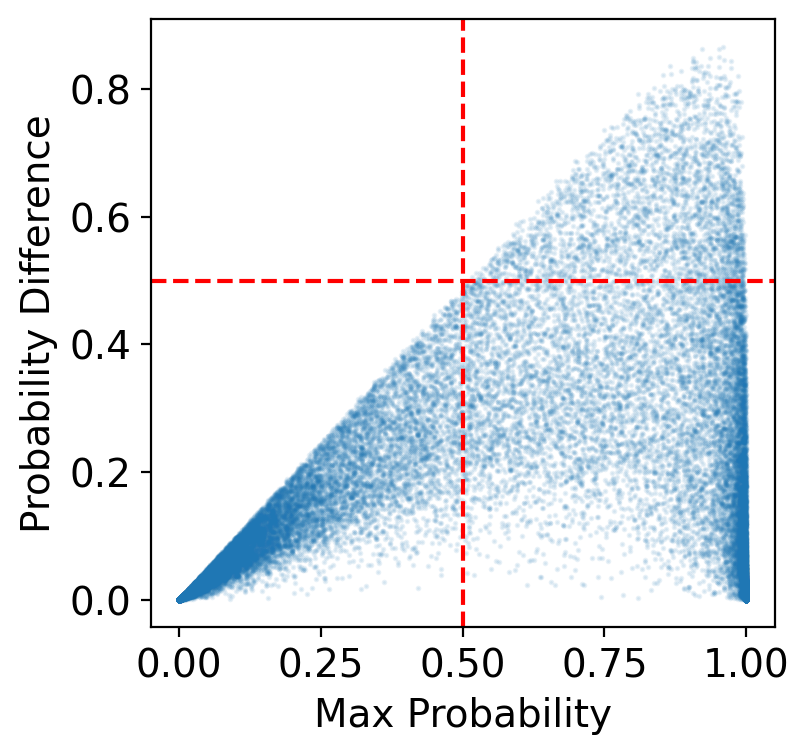

In [26]:
# get cutoffs
fig, ax = plt.subplots(figsize=[4, 4])
ax.grid(False)
ax.scatter(sensitivity, specificity, s=1, alpha=0.1)
ax.set(xlabel='Max Probability', ylabel='Probability Difference')
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.plot([xmin, xmax], [0.5]*2, color='r', linestyle='--')
ax.plot([0.5]*2, [ymin, ymax], color='r', linestyle='--')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

(-0.043279544264078144, 0.9088704295456409)

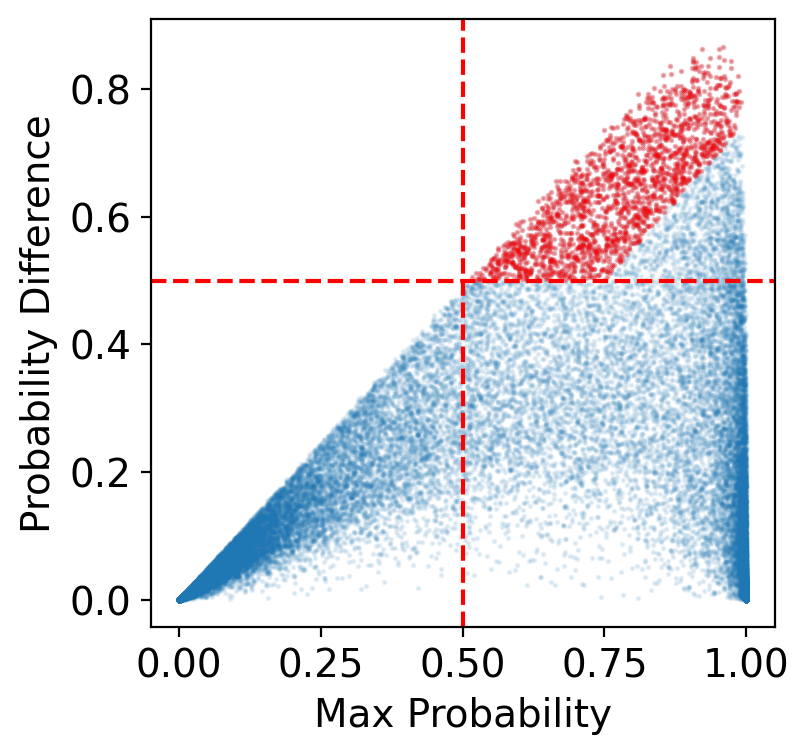

In [48]:
# filter down
y_filtered = y_pred.loc[(sensitivity >= 0.5) &
                        (specificity >= sensitivity - 0.25) &
                        (specificity >= 0.5)].copy()
# get cutoffs
fig, ax = plt.subplots(figsize=[4, 4])
ax.grid(False)
ax.scatter(sensitivity, specificity, s=1, alpha=0.1)
ax.scatter(sensitivity.loc[y_filtered.index], specificity.loc[y_filtered.index], s=1, alpha=0.25, color='r')
ax.set(xlabel='Max Probability', ylabel='Probability Difference')
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.plot([xmin, xmax], [0.5]*2, color='r', linestyle='--')
ax.plot([0.5]*2, [ymin, ymax], color='r', linestyle='--')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

(-0.043279544264078144, 0.9088704295456409)

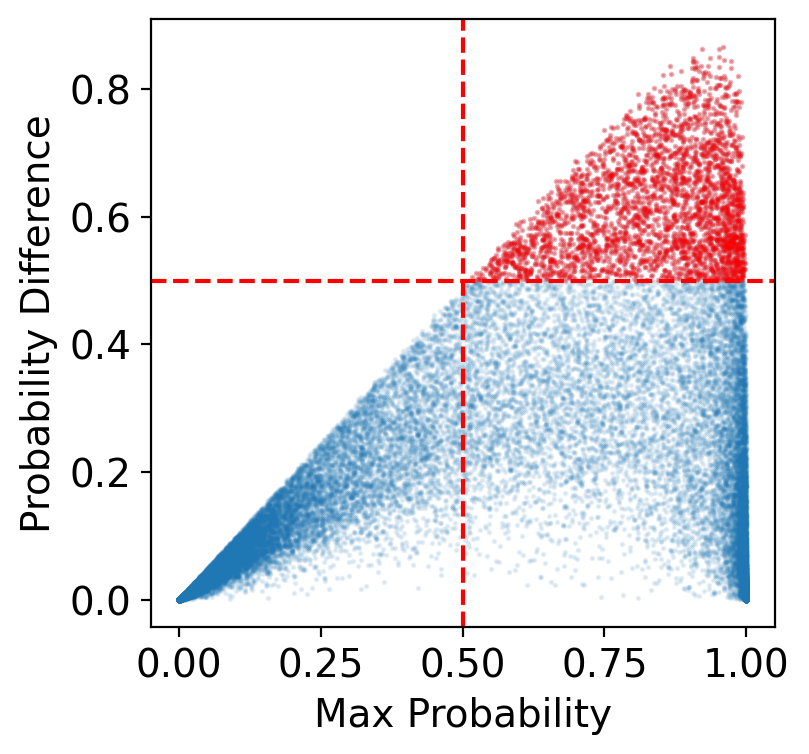

In [49]:
# filter down
y_filtered = y_pred.loc[(sensitivity >= 0.5) & (specificity >= 0.5)].copy()
# get cutoffs
fig, ax = plt.subplots(figsize=[4, 4])
ax.grid(False)
ax.scatter(sensitivity, specificity, s=1, alpha=0.1)
ax.scatter(sensitivity.loc[y_filtered.index], specificity.loc[y_filtered.index], s=1, alpha=0.25, color='r')
ax.set(xlabel='Max Probability', ylabel='Probability Difference')
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.plot([xmin, xmax], [0.5]*2, color='r', linestyle='--')
ax.plot([0.5]*2, [ymin, ymax], color='r', linestyle='--')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

In [50]:
# read in mcpas and iedb for the paired identities
# load in the IEDB data
df = pd.read_csv('/ssd1/dchen/GNN_PEPTIDE_TCR/data/iedb.receptor_table_export_1692393367.csv', index_col=0)
df = df.reset_index().iloc[:, 1:]
df = df.dropna(subset=['Chain 1 - CDR3 Curated', 'Chain 2 - CDR3 Curated'])
df_iedb = df.copy()
# load in the McPAS data
df = pd.read_csv('/ssd1/dchen/GNN_PEPTIDE_TCR/data/McPAS-TCR.csv', encoding='windows-1252')
mask = (df['Species'] == 'Human') & (df['MHC'].isin(['HLA-A*02:01','HLA-A*2:01','HLA-A*2:01,*6:801']))
df = df.dropna(subset=['CDR3.alpha.aa','CDR3.beta.aa'])
df_mcpas = df.copy()

/home/dchen/anaconda3/envs/base_py38/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3378: DtypeWarning: Columns (2,10,11,12,13,14,15,16,18,19,20,21,22,23,28,29,34,35,42,43,44,45,46,47,48,49,50,57,58,63,64) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/dchen/anaconda3/envs/base_py38/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3378: DtypeWarning: Columns (13,17,24,26,28) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
# CDR3s were then chosen from this list and VJ genes were inferred